# Visualize Task RDMs, @ parcel level and network level

In [98]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import hcp_utils as hcp
import tools
import nilearn.plotting as plotting
from importlib import reload
tools = reload(tools)
import wbplot
import pandas as pd
import matplotlib.image as img 

#### Set up basic parameters

In [124]:
basedir = '/home/ti236/taku/multiTaskVAE/'

networkdef = np.loadtxt('/home/ti236/AnalysisTools/ColeAnticevicNetPartition/cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('/home/ti236/AnalysisTools/ColeAnticevicNetPartition/cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

glasserfilename = '/home/ti236/AnalysisTools/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = np.squeeze(nib.load(glasserfilename).get_data())
figuredir = basedir + 'docs/figures/task_rsa/'


#### split up sensorimotor from association network color palettes
color1, color2 = sns.color_palette(palette='Set2',n_colors=2)
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']

roi_id = np.zeros((nParcels,))
tmp = {}
netcount = 0
for network in networkmappings:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        if network in associationnets:
            tmp[roi] = color1 #'r'
            roi_id[roi] = -1
        else:
            tmp[roi] = color2 #'b'
            roi_id[roi] = 1
    netcount += 1
    
roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])

<ipython-input-124-55e2e63f663b>:35: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  glasser = np.squeeze(nib.load(glasserfilename).get_data())


In [7]:
subIDs=['02','03','04','06','08','09','10','12','14','15','18','20','22','25','27','29','31','17','19','21','24','26','28','30']
sessIDs = ['a1','a2','b1','b2']
runs = range(1,9)

## Whole-brain RSM (parcellated and vertex-wise)

In [174]:
tools = reload(tools)
n_tasks = 45
wb_rsm_parcellated = np.zeros((len(subIDs),n_tasks,n_tasks))
wb_rsm_64k = np.zeros((len(subIDs),n_tasks,n_tasks))
scount = 0
for sub in subIDs:
    wb_rsms, task_index = tools.computeSubjRSM(sub,space='parcellated',wholebrain=True)
    wb_rsm_parcellated[scount,:,:] = wb_rsms
    
    wb_rsms, task_index = tools.computeSubjRSM(sub,space='vertex',wholebrain=True)
    wb_rsm_64k[scount,:,:] = wb_rsms
    scount += 1

#### Plot

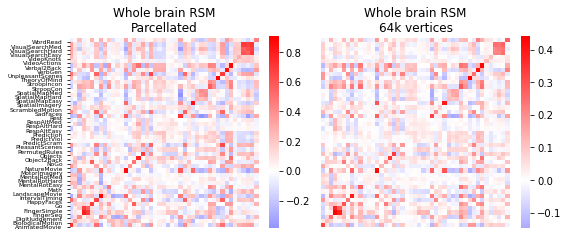

In [182]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
ax = sns.heatmap(np.arctanh(np.mean(wb_rsm_parcellated,axis=0)),square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.title('Whole brain RSM\nParcellated',fontsize=12)
plt.yticks(np.arange(len(unique_tasks)),task_index,fontsize=6,rotation=0);
plt.xticks([])

plt.subplot(1,2,2)
ax = sns.heatmap(np.arctanh(np.mean(wb_rsm_64k,axis=0)),square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.title('Whole brain RSM\n64k vertices',fontsize=12)
plt.yticks([]);
plt.xticks([])
plt.tight_layout()
plt.savefig(figuredir + 'WholeBrainRSMs.png',dpi=300)

# Network analysis (using parcels) -- compute subject-specific RDMs (cross-validated across runs)

In [100]:
tools = reload(tools)
n_tasks = 45
rsms_net_allsubjs = np.zeros((len(orderednetworks),len(subIDs),n_tasks,n_tasks))
scount = 0
for sub in subIDs:
    rsms, task_index = tools.computeSubjRSM(sub,space='parcellated')
    i = 0
    for net in orderednetworks:
        rsms_net_allsubjs[i,scount,:,:] = rsms[net]
        i += 1
    scount += 1

#### Compute dimensionality or RDMs and plot dimensionality of each network

In [183]:
rsm_dim = {}
rsm_dim['Subject'] = []
rsm_dim['Dimensionality'] = []
rsm_dim['Network'] = []
netcount = 0
for net in range(len(orderednetworks)):
    for scount in range(len(subIDs)):
        rsm_dim['Subject'].append(subIDs[scount])
        rsm_dim['Network'].append(OrderedNetworks[net])
        rsm_dim['Dimensionality'].append(tools.getDimensionality(np.arctanh(rsms_net_allsubjs[net,scount,:,:])))
rsm_dim = pd.DataFrame(rsm_dim)

/gpfs/loomis/project/murray/ti236/conda_envs/taku/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/loomis/project/murray/ti236/conda_envs/taku/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/loomis/project/murray/ti236/conda_envs/taku/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 58.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


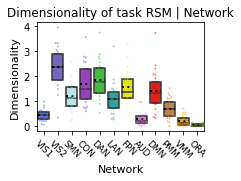

In [185]:
plt.figure(figsize=(3,2))
# plt.figure(figsize=(10,7))
ax = sns.boxplot(x="Network",y="Dimensionality",data=rsm_dim,
            palette=networkpalette,
           meanline=True,showmeans=True,meanprops={'linewidth':2,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0);
sns.swarmplot(x="Network",y="Dimensionality",data=rsm_dim,
            palette=networkpalette,
            alpha=0.5,size=2,dodge=True);
plt.title('Dimensionality of task RSM | Network', fontsize=12);
plt.xlabel('Network',fontsize=11);
plt.ylabel('Dimensionality',fontsize=11);
plt.xticks(fontsize=9,rotation=-45);
plt.yticks(fontsize=10);
plt.savefig(figuredir + 'RSMDimensionality_NetworkLevel.png',dpi=300)

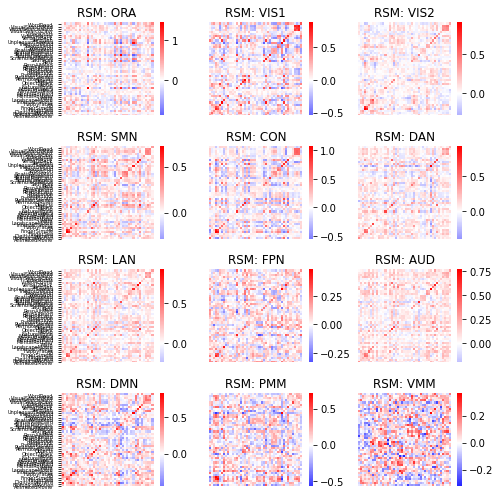

In [186]:
plt.figure(figsize=(7,7))
i = 0
for net in OrderedNetworks:
    plt.subplot(4,3,i+1)
    rsmnet = np.mean(rsms_net_allsubjs[i,:,:,:],axis=0)
    ax = sns.heatmap(np.arctanh(rsmnet),square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
    ax.invert_yaxis()
    plt.title('RSM: ' + OrderedNetworks[i-1])
#     plt.xticks(np.arange(len(unique_tasks)),unique_tasks,fontsize=8,rotation=-45)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    if i in [0,3,6,9]:
        plt.yticks(np.arange(len(unique_tasks)),unique_tasks,fontsize=5,rotation=0)
    else:
        plt.yticks([])
    i += 1
plt.tight_layout()
plt.savefig(figuredir + 'NetworkLevelRSMs_Parcellated.png',dpi=300)

____

## Vertex-wise analysis -- compute subject-specific RDMs (cross-validated across runs)

In [92]:
n_tasks = 45
rsms_parcels_allsubjs = np.zeros((nParcels,len(subIDs),n_tasks,n_tasks))
scount = 0
for sub in subIDs:
    rsms, task_index = tools.computeSubjRSM(sub,space='vertex')
    for roi in range(nParcels):
        rsms_parcels_allsubjs[roi,scount,:,:] = rsms[roi]
    scount += 1

#### Compute dimensionality or RDMs and plot dimensionality of each ROI

In [187]:
rsm_rois = np.zeros((nParcels,len(subIDs)))
for roi in range(nParcels):
    for scount in range(len(subIDs)):
        rsm_rois[roi,scount] = tools.getDimensionality(np.arctanh(rsms_parcels_allsubjs[roi,scount,:,:]))

#### Plot dimensionality of each ROI and compare with 'margulies' gradient and myelin map

In [189]:
tmproi_rsm = np.mean(rsm_rois,axis=1)

tmp = np.hstack((tmproi_rsm[180:],tmproi_rsm[:180]))
wbplot.pscalar(figuredir + 'Parcellated_RSMDimensionality.png',tmp,cmap='magma')

margulies_gradient_64k = np.loadtxt(basedir + 'derivatives/results/MarguliesGradientParcellated.csv',delimiter=',')
margulies_gradient = np.zeros((nParcels,))
for roi in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    margulies_gradient[roi] = np.mean(margulies_gradient_64k[roi_ind])
tmp = np.hstack((margulies_gradient[180:],margulies_gradient[:180]))
wbplot.pscalar(figuredir + 'Parcellated_MarguliesGradient.png',tmp,cmap='magma')

myelin_map_64k = np.loadtxt(basedir + 'derivatives/results/MyelinMapParcellated_v1.csv',delimiter=',')
myelin_map = np.zeros((nParcels,))
for roi in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    myelin_map[roi] = np.mean(myelin_map_64k[roi_ind])
tmp = np.hstack((myelin_map[180:],myelin_map[:180]))
wbplot.pscalar(figuredir + 'Parcellated_MyelinMap.png',tmp,cmap='magma')



pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


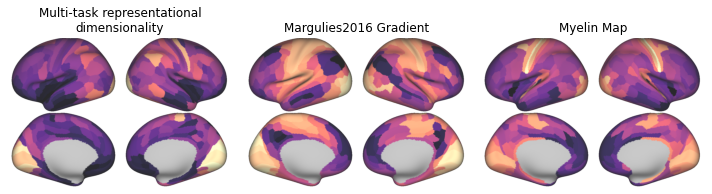

In [194]:
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
im = img.imread(figuredir + 'Parcellated_RSMDimensionality.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Multi-task representational\ndimensionality',fontsize=12)
plt.tight_layout()

plt.subplot(1,3,2)
im = img.imread(figuredir + 'Parcellated_MarguliesGradient.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Margulies2016 Gradient',fontsize=12)
plt.tight_layout()

plt.subplot(1,3,3)
im = img.imread(figuredir + 'Parcellated_MyelinMap.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Myelin Map',fontsize=12)
plt.tight_layout()

plt.savefig(figuredir + 'Parcellated_RSMDimensionalityWithGradients.png',dpi=300)

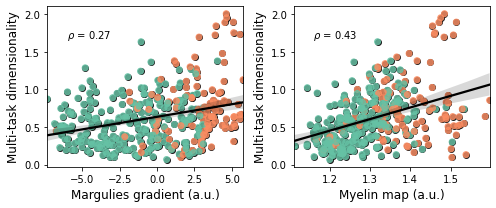

In [191]:
plt.figure(figsize=(7,3))
# fig, ax = plt.subplots(figsize=(6, 3))
plt.subplot(1,2,1)
sns.regplot(x=margulies_gradient,y=tmproi_rsm,color='k',fit_reg=False)
sns.regplot(x=margulies_gradient,y=tmproi_rsm,color='k',scatter_kws={'color':roiColorsByNetwork})
plt.ylabel('Multi-task dimensionality',fontsize=12)
plt.xlabel('Margulies gradient (a.u.)',fontsize=12)
# plt.title('',fontsize=30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
rho, p = stats.spearmanr(margulies_gradient,tmproi_rsm)
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$\rho$'+ ' = ' + str(rho),
             xy=(0.1,.8),fontsize=10,xycoords='axes fraction')

plt.subplot(1,2,2)
sns.regplot(x=myelin_map,y=tmproi_rsm,color='k',fit_reg=False)
sns.regplot(x=myelin_map,y=tmproi_rsm,color='k',scatter_kws={'color':roiColorsByNetwork})
plt.ylabel('Multi-task dimensionality',fontsize=12)
plt.xlabel('Myelin map (a.u.)',fontsize=12)
# plt.title('',fontsize=30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
rho, p = stats.spearmanr(myelin_map,tmproi_rsm)
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$\rho$'+ ' = ' + str(rho),
             xy=(0.1,.8),fontsize=10,xycoords='axes fraction')
plt.tight_layout()
plt.savefig(figuredir + 'ScatterPlot_DimensionalityXMyelinXMargulies.png',dpi=300)

### Plot by network

In [192]:
rsm_dim_parcel = {}
rsm_dim_parcel['Subject'] = []
rsm_dim_parcel['Dimensionality'] = []
rsm_dim_parcel['Network'] = []
netcount = 0
for net in orderednetworks:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    for scount in range(len(subIDs)):
        rsm_dim_parcel['Subject'].append(subIDs[scount])
        rsm_dim_parcel['Network'].append(OrderedNetworks[netcount])
        rsm_dim_parcel['Dimensionality'].append(np.mean(rsm_rois[net_ind,scount],axis=0))
    netcount += 1
rsm_dim_parcel = pd.DataFrame(rsm_dim_parcel)

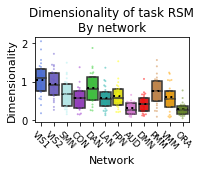

In [200]:

plt.figure(figsize=(3,2.5))
# plt.figure(figsize=(10,7))
ax = sns.boxplot(x="Network",y="Dimensionality",data=rsm_dim_parcel,
            palette=networkpalette,
           meanline=True,showmeans=True,meanprops={'linewidth':2,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0);
sns.swarmplot(x="Network",y="Dimensionality",data=rsm_dim_parcel,
            palette=networkpalette,
            alpha=0.5,size=2,dodge=True);
plt.title('Dimensionality of task RSM\nBy network', fontsize=12);
plt.xlabel('Network',fontsize=11);
plt.ylabel('Dimensionality',fontsize=11);
plt.xticks(fontsize=9,rotation=-45);
plt.yticks(fontsize=10);
plt.tight_layout()
plt.savefig(figuredir + 'RSMDimensionality_NetworkDescription64k.png',dpi=300)